In [1]:
import import_ipynb
from fetch_data import get_stock_data
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import joblib
import os
import sys
import datetime
import numpy as np
import pandas as pd
import yfinance as yf

import matplotlib.pyplot as plt

Index(['Open', 'High', 'Low', 'Close'], dtype='object')
Present date: 2025-10-31 00:00:00-04:00
Next valid date: 2025-11-02 23:00:00-05:00
Index(['Date', 'Close', 'Close_lag_1', 'Open_lag_1', 'High_lag_1', 'Low_lag_1',
       'Close_lag_2', 'Open_lag_2', 'High_lag_2', 'Low_lag_2', 'Close_lag_3',
       'Open_lag_3', 'High_lag_3', 'Low_lag_3', 'Close_lag_4', 'Open_lag_4',
       'High_lag_4', 'Low_lag_4', 'Close_lag_5', 'Open_lag_5', 'High_lag_5',
       'Low_lag_5', 'Close_lag_6', 'Open_lag_6', 'High_lag_6', 'Low_lag_6'],
      dtype='object')


In [2]:
def train_xgboost_model(ticker: str):
    df = get_stock_data(ticker.lower())
    X = df.drop(['Date', 'Close'], axis=1)
    Y = df["Close"]
    X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.1, shuffle=False)
    params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "eta": 0.05,
        "max_depth": 6,
        "subsample": 1,
        "colsample_bytree": 0.8,
        "seed": 101
    }
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_valid, label=y_valid)
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=500,
        evals=[(dtrain, 'train'), (dvalid, 'valid')],
        early_stopping_rounds=50,
        verbose_eval=50
    )
    y_pred = model.predict(dvalid)
    validation_dates = df['Date'].iloc[-len(y_valid):]
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    mae = mean_absolute_error(y_valid, y_pred)
    mape = np.mean(np.abs((y_valid - y_pred) / (y_valid + 1e-9))) * 100

    print(f"Model Performance for {ticker.upper()}:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"MAPE: {mape:.2f}%")
    plt.figure(figsize=(12, 6))
    plt.plot(validation_dates, y_valid.values, label='Actual Close Price', linewidth=2)
    plt.plot(validation_dates, y_pred, label='Predicted Close Price', linewidth=2)
    plt.title(f'{ticker.upper()} Model Analysis', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel("Predicted 'Close' Price of the Stock")
    plt.legend()
    plt.grid(True)
    plt.show()
    return model


[0]	train-rmse:25.21404	valid-rmse:125.36941
[50]	train-rmse:2.25493	valid-rmse:39.07137
[100]	train-rmse:0.59857	valid-rmse:33.39142
[150]	train-rmse:0.42307	valid-rmse:33.03560
[200]	train-rmse:0.36313	valid-rmse:32.97680
[227]	train-rmse:0.33955	valid-rmse:32.98303
Model Performance for NVDA:
RMSE: 32.9858
MAE:  24.7810
MAPE: 15.12%


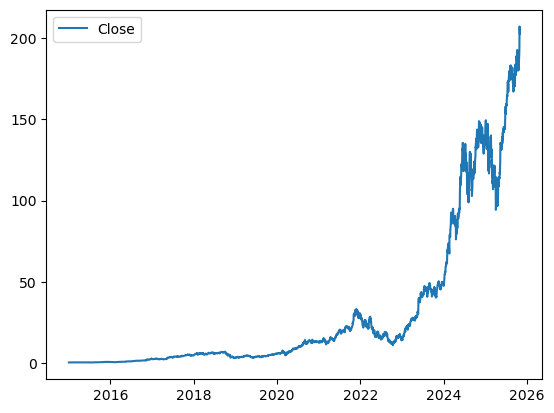

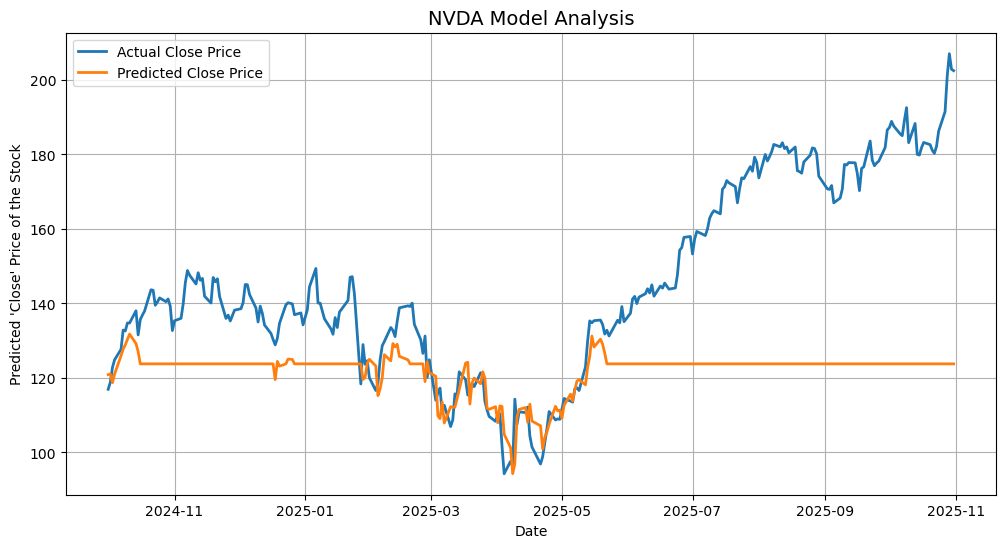

In [3]:
train_xgboost_model("NVDA")

[0]	train-rmse:59.10752	valid-rmse:131.07844
[50]	train-rmse:4.96807	valid-rmse:21.98501
[100]	train-rmse:1.40770	valid-rmse:15.15971
[150]	train-rmse:1.17378	valid-rmse:14.81626
[200]	train-rmse:1.03651	valid-rmse:14.82146
Model Performance for AAPL:
RMSE: 14.8215
MAE:  10.4259
MAPE: 4.38%


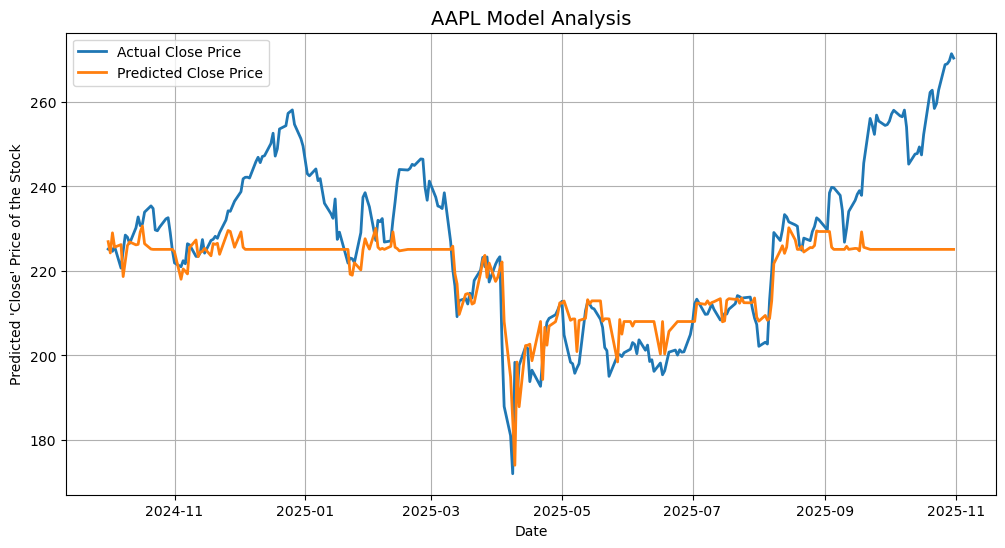

In [4]:
train_xgboost_model("AAPL")

In [5]:
from sklearn.preprocessing import StandardScaler

In [6]:
def train_random_forest(ticker: str):
    df = get_stock_data(ticker.lower())
    X = df.drop(['Date', 'Close'], axis=1)
    y = df['Close']
    split_idx = int(len(df) * 0.7)
    X_train, X_valid = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_valid = y.iloc[:split_idx], y.iloc[split_idx:]
    dates_valid = df['Date'].iloc[split_idx:]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)
    model = RandomForestRegressor(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        n_jobs=-1,
        oob_score=False
    )
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_valid_scaled)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    mae = mean_absolute_error(y_valid, y_pred)
    mape = np.mean(np.abs((y_valid - y_pred) / (y_valid + 1e-9))) * 100

    print(f"Model Performance for {ticker.upper()}:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"MAPE: {mape:.2f}%")
    plt.figure(figsize=(12, 6))
    plt.plot(dates_valid, y_valid.values, label='Actual Close Price', linewidth=2)
    plt.plot(dates_valid, y_pred, label='Predicted Close Price', linewidth=2)
    plt.title(f'{ticker.upper()} Random Forest Model Analysis', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel("Predicted 'Close' Price of the Stock")
    plt.legend()
    plt.grid(True)
    plt.show()
    return model

Model Performance for AAPL:
RMSE: 35.9442
MAE:  25.2618
MAPE: 11.41%


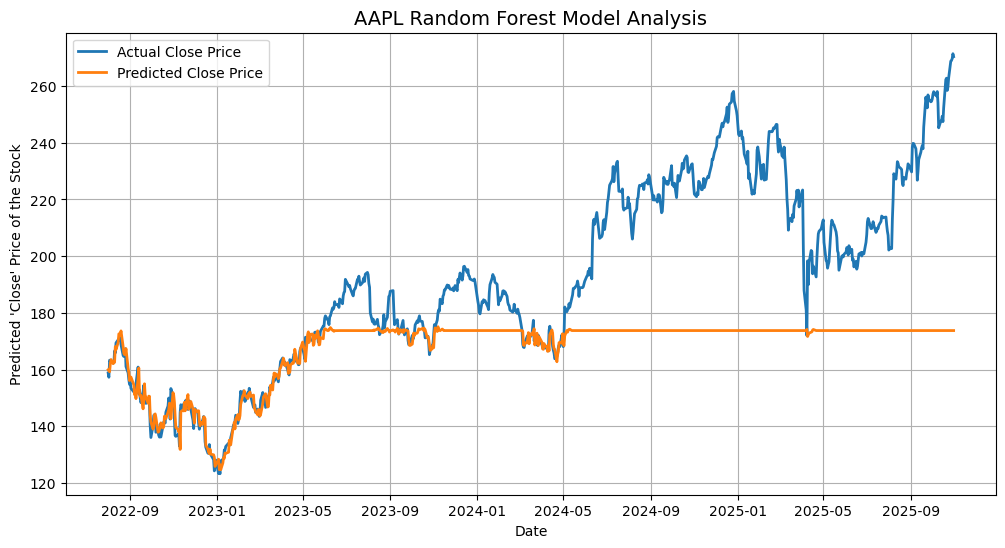

RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)

In [7]:
train_random_forest("AAPL")

In [11]:
def prophet_predict(ticker: str, periods: int = 30):
    df = get_stock_data(ticker.lower())
    df = df.sort_values('Date').reset_index(drop=True)
    df_prophet = df.rename(columns={'Date': 'ds', 'Close': 'y'})
    df_prophet['ds'] = pd.to_datetime(df_prophet['ds']).dt.tz_localize(None)
    split_idx = int(len(df_prophet) * 0.7)
    train = df_prophet.iloc[:split_idx]
    validation = df_prophet.iloc[split_idx:]
    lag_features = [col for col in df.columns if "lag" in col]
    model = Prophet(yearly_seasonality=True,weekly_seasonality=True,seasonality_mode="additive")
    for name in lag_features:
        model.add_regressor(name)
    model.fit(train)
    forecast_val = model.predict(validation[["ds"] + lag_features] if lag_features else validation[["ds"]])
    y_true = validation['y'].values
    y_pred = forecast_val['yhat'].values
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print(f"\nModel Performance for {ticker.upper()}:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"MAPE: {mape:.2f}%")

    future = model.make_future_dataframe(periods=periods)
    future['ds'] = pd.to_datetime(future['ds']).dt.tz_localize(None)
    for name in lag_features:
        future[name] = 0  
    forecast_future = model.predict(future)
    fig = plt.figure(figsize=(12, 6))
    plt.plot(df["Date"].iloc[-365:], df["Close"].iloc[-365:], label="Actual", color="blue")

    plt.plot(forecast_val["ds"], forecast_val["yhat"], label="Validation Forecast", color="orange")
    plt.fill_between(
        forecast_val["ds"],
        forecast_val["yhat_lower"],
        forecast_val["yhat_upper"],
        color="orange",
        alpha=0.2,
        label="Validation Uncertainty"
    )

    plt.plot(
        forecast_future["ds"].iloc[-periods:],
        forecast_future["yhat"].iloc[-periods:],
        label=f"Future {periods}-Day Forecast"
    )
    plt.fill_between(
        forecast_future["ds"].iloc[-periods:],
        forecast_future["yhat_lower"].iloc[-periods:],
        forecast_future["yhat_upper"].iloc[-periods:],
        color="green",
        alpha=0.4,
        label="Future Uncertainty"
    )

    plt.xlabel("Date")
    plt.ylabel("Predicted `Close` price of Stock")
    plt.title(f"{ticker.upper()} Model Forecast ({periods} Days Ahead)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return model , df

09:32:21 - cmdstanpy - INFO - Chain [1] start processing
09:32:22 - cmdstanpy - INFO - Chain [1] done processing



Model Performance for NVDA:
RMSE: 3.2375
MAE:  2.1013
MAPE: 2.55%


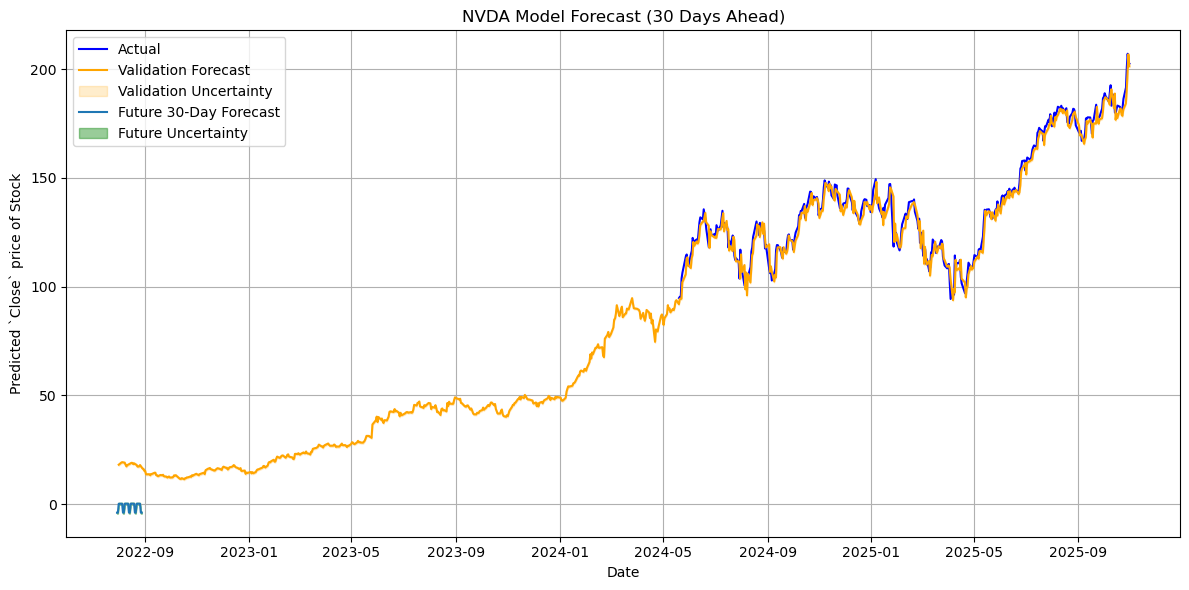

(<prophet.forecaster.Prophet at 0x259af3e7440>,
                           Date       Close  Close_lag_1  Open_lag_1  \
 0    2015-01-02 00:00:00-05:00    0.483038     0.000000    0.000000   
 1    2015-01-05 00:00:00-05:00    0.474880     0.483038    0.483038   
 2    2015-01-06 00:00:00-05:00    0.460482     0.474880    0.483038   
 3    2015-01-07 00:00:00-05:00    0.459282     0.460482    0.475599   
 4    2015-01-08 00:00:00-05:00    0.476559     0.459282    0.463841   
 ...                        ...         ...          ...         ...   
 2720 2025-10-27 00:00:00-04:00  191.490005   186.259995  183.839996   
 2721 2025-10-28 00:00:00-04:00  201.029999   191.490005  189.990005   
 2722 2025-10-29 00:00:00-04:00  207.039993   201.029999  193.050003   
 2723 2025-10-30 00:00:00-04:00  202.889999   207.039993  207.979996   
 2724 2025-10-31 00:00:00-04:00  202.490005   202.889999  205.149994   
 
       High_lag_1   Low_lag_1  Close_lag_2  Open_lag_2  High_lag_2   Low_lag_2  \
 0  

In [12]:
prophet_predict("NVDA")

09:32:23 - cmdstanpy - INFO - Chain [1] start processing
09:32:24 - cmdstanpy - INFO - Chain [1] done processing



Model Performance for AAPL:
RMSE: 3.4623
MAE:  2.4008
MAPE: 1.28%


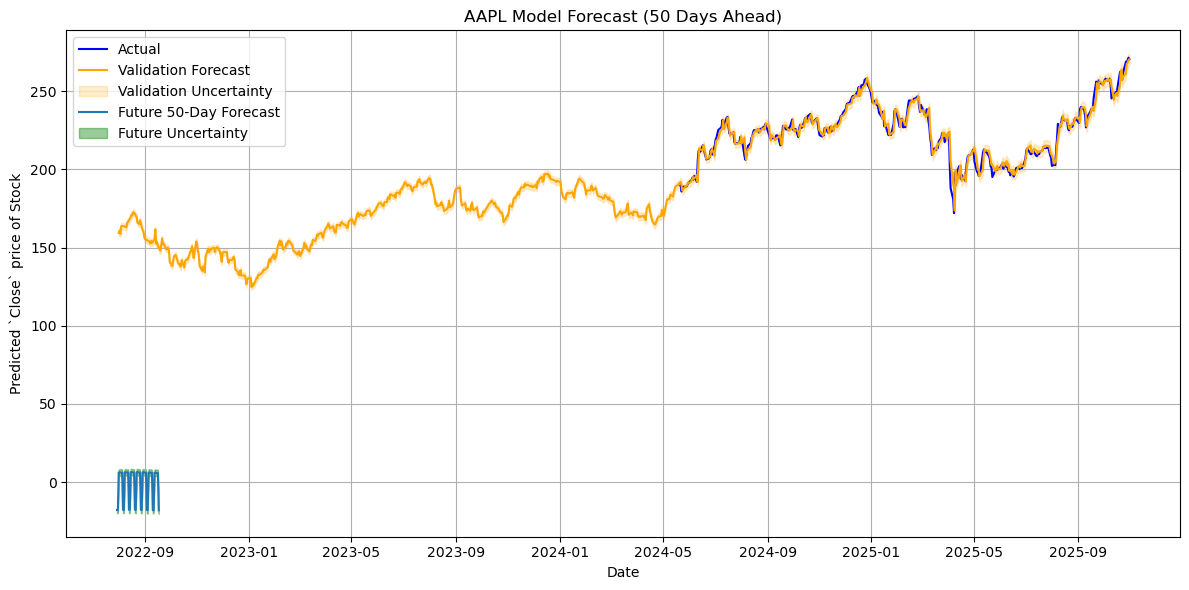

(<prophet.forecaster.Prophet at 0x259af363410>,
                           Date       Close  Close_lag_1  Open_lag_1  \
 0    2015-01-02 00:00:00-05:00   24.261049     0.000000    0.000000   
 1    2015-01-05 00:00:00-05:00   23.577572    24.261049   24.718176   
 2    2015-01-06 00:00:00-05:00   23.579796    23.577572   24.030261   
 3    2015-01-07 00:00:00-05:00   23.910437    23.579796   23.641929   
 4    2015-01-08 00:00:00-05:00   24.829132    23.910437   23.788387   
 ...                        ...         ...          ...         ...   
 2720 2025-10-27 00:00:00-04:00  268.809998   262.820007  261.190002   
 2721 2025-10-28 00:00:00-04:00  269.000000   268.809998  264.880005   
 2722 2025-10-29 00:00:00-04:00  269.700012   269.000000  268.989990   
 2723 2025-10-30 00:00:00-04:00  271.399994   269.700012  269.279999   
 2724 2025-10-31 00:00:00-04:00  270.369995   271.399994  271.989990   
 
       High_lag_1   Low_lag_1  Close_lag_2  Open_lag_2  High_lag_2   Low_lag_2  \
 0  

In [13]:
prophet_predict("AAPL",50)